In [1]:
!pip install hoggorm

In [2]:
!pip install hoggormplot

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import hoggorm as ho
import hoggormplot as hop

from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, cross_val_predict, RepeatedKFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.cross_decomposition import PLSRegression

In [4]:
!pip install numpy==1.23

In [6]:
import sys
sys.path.append('/content/drive/My Drive/Master Thesis Spring 2024')
from preprocessing import preprocessing_PLS_RENT

In [7]:
X_train, Y_train, X_test, Y_test, df_encoded = preprocessing_PLS_RENT("TINE.Ystekar.Norvegia.v1.csv", train_index=1459)

# PLSR USING ALL VARIABLES

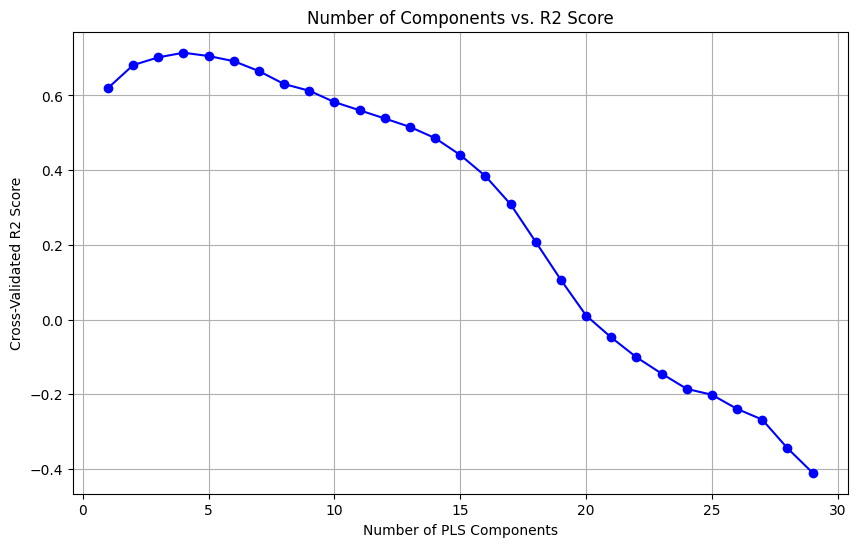

In [9]:

# Define groups for Leave-One-Group-Out cross-validation
groups = X_train['Bs_Batch'].values

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

# Initialize LeaveOneGroupOut for cross-validation
logo = LeaveOneGroupOut()

# Initialize lists to store the number of components and corresponding R^2 scores
component_list = []
r2_scores = []

# Cross-validation to find the optimal number of components in PLS Regression
for i in range(1, 30):
    pls = PLSRegression(n_components=i, scale=True)
    y_cv_pred = cross_val_predict(pls, X_train, Y_train, groups=groups, cv=logo)
    r2_cv = r2_score(Y_train, y_cv_pred)
    component_list.append(i)
    r2_scores.append(r2_cv)

# Plot the number of components against R^2 scores
plt.figure(figsize=(10, 6))
plt.plot(component_list, r2_scores, marker='o', linestyle='-', color='blue')
plt.title('Number of Components vs. R2 Score')
plt.xlabel('Number of PLS Components')
plt.ylabel('Cross-Validated R2 Score')
plt.grid(True)
plt.show()


In [40]:
# Define groups for Leave-One-Group-Out cross-validation
groups = X_train['Bs_Batch'].values

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

# Initialize the LeaveOneGroupOut for cross-validation
logo = LeaveOneGroupOut()

# Define PLS with 2 components. This gives best test score.
pls = PLSRegression(n_components=2, scale=True)

# Use cross_val_predict
y_cv_pred = cross_val_predict(pls, X_train.drop(['Bs_Batch'], axis=1), Y_train, groups=groups, cv=logo)
r2_cv = r2_score(Y_train, y_cv_pred)
mse_cv = mean_squared_error(Y_train, y_cv_pred)
pls.fit(X_train.drop(['Bs_Batch'], axis=1), Y_train)

# Predict and evaluate on training and test sets also excluding 'Bs_Batch'
y_train_pred = pls.predict(X_train.drop(['Bs_Batch'], axis=1))
y_test_pred = pls.predict(X_test.drop(['Bs_Batch'], axis=1))
mse_train = mean_squared_error(Y_train, y_train_pred)
mse_test = mean_squared_error(Y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(Y_train, y_train_pred)
r2_test = r2_score(Y_test, y_test_pred)

# Print the results
print(f"Using PLS with 2 components")
print(f"Cross-validation - Average R²: {r2_cv:.4f}, Average MSE: {mse_cv:.4f}")
print(f"Training set - RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}")
print(f"Test set - RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")


Using PLS with 2 components
Cross-validation - Average R²: 0.6838, Average MSE: 0.0881
Training set - RMSE: 0.2450, R²: 0.7844
Test set - RMSE: 0.4071, R²: 0.5831


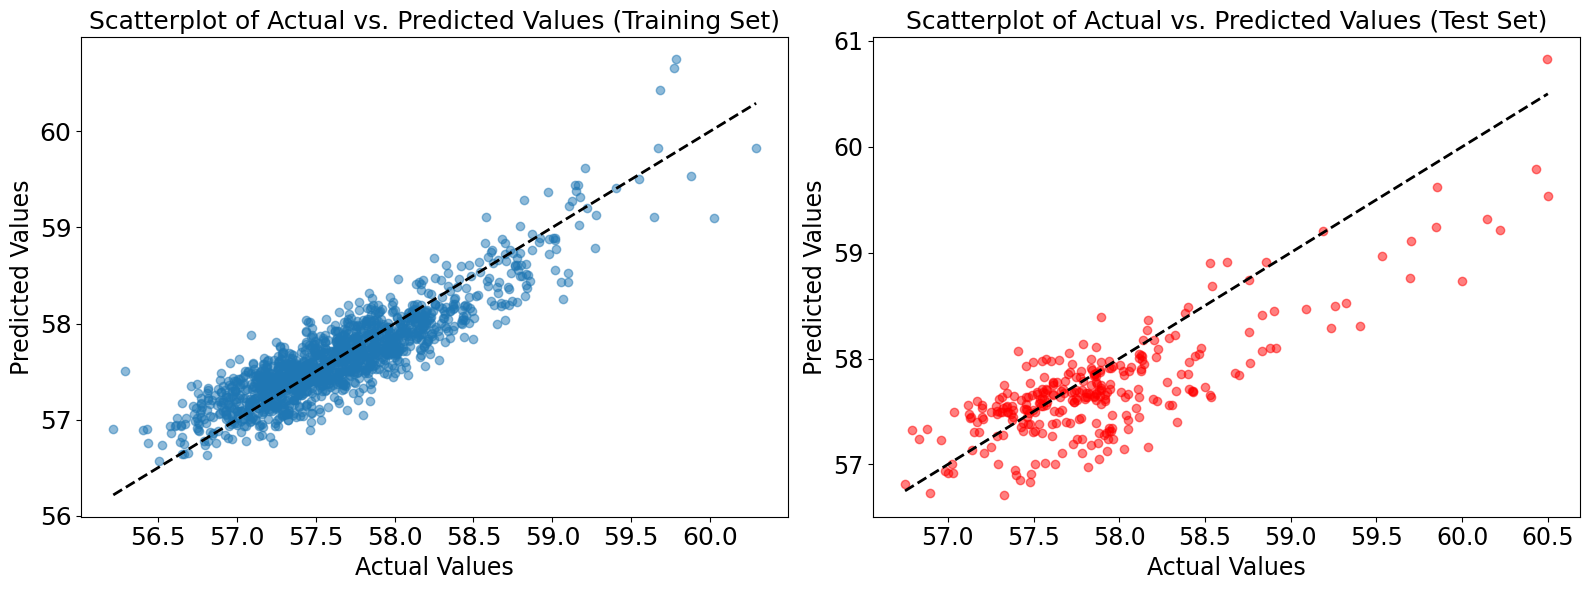

In [41]:
# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # One row, two columns

# Subplot 1: Training Set
ax[0].scatter(Y_train, y_train_pred, alpha=0.5)
ax[0].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'k--', lw=2)  # Line for perfect prediction
ax[0].set_xlabel('Actual Values', fontsize=17)
ax[0].set_ylabel('Predicted Values', fontsize=17)
ax[0].set_title('Scatterplot of Actual vs. Predicted Values (Training Set)', fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=18)

# Subplot 2: Test Set
ax[1].scatter(Y_test, y_test_pred, alpha=0.5, color="red")
ax[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
ax[1].set_xlabel('Actual Values', fontsize=17)
ax[1].set_ylabel('Predicted Values', fontsize=17)
ax[1].set_title('Scatterplot of Actual vs. Predicted Values (Test Set)', fontsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=17)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Display the plots
plt.show()

In [42]:
def vip(x, model):
    # Extract necessary matrices from PLS model
    t = model.x_scores_  # Scores
    w = model.x_weights_  # Weights
    q = model.y_loadings_  # Y loadings
    m, p = x.shape
    h = t.shape[1]

    vips = np.zeros((p,))

    # Calculate the inner relationship for VIP
    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    # Compute VIP scores for each variable
    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j])) ** 2 for j in range(h)])
        vips[i] = np.sqrt(p * (s.T @ weight) / total_s)

    return vips

# Prepare data by dropping identifier column
X_train_dropped = X_train.drop(['Bs_Batch'], axis=1)

# Calculate VIP scores using the defined function and PLS model
vip_scores = vip(X_train_dropped, pls)

# Convert VIP scores into a Pandas Series for easier handling and sorting
vip_series = pd.Series(vip_scores, index=X_train_dropped.columns)

# Print the VIP scores sorted in descending order
print(vip_series.sort_values(ascending=False))




Bu_start2casomaticTime    2.589995
Bu_cut2casomaticTime      2.498496
Bu_coag2casomaticTime     2.481256
Bu_duration               2.041004
Yk_start2endTime          1.962124
                            ...   
Bs_ph_pHo                 0.108720
Yk_timeCut                0.091462
Yk_brukssyreToLopeSumT    0.089893
Bs_temp_Time_stage26      0.085574
Yk_cutToMy1SumT           0.082541
Length: 83, dtype: float64


In [43]:
# Sort VIP scores from highest to lowest
sorted_vip_series = vip_series.sort_values(ascending=False)

# Filter and retain features with VIP scores greater than 0.8
important_features = sorted_vip_series[sorted_vip_series > 0.8].index.tolist()

# Print the important features sorted by their importance
print("Important Features (sorted by importance):")
for feature in important_features:
    print(feature)


Important Features (sorted by importance):
Bu_start2casomaticTime
Bu_cut2casomaticTime
Bu_coag2casomaticTime
Bu_duration
Yk_start2endTime
Bu_emptytime
Yk_tommingToendSumT
Yk_timeTomming
Yk_tommingToendAvgT
Bs_temp_Time_stage130
Bs_alder
Yk_mengde
Ost_wilab_ph_4t
Bs_temp_end_cooled
Bu_tempmean
Yk_mysemengde_r6001
Bu_tempmax
Bs_artikkel_R6024
Bs_artikkel_R6024Cryostart
Yk_ystevannToTommingSumT
Ost_phReduction4T
Yk_start2tommingTime
Yk_timeYstevann
Yk_tommingToendStdT
Bs_wilab_ph
Si_wilab_prot_ftir
Bs_temp_temp_cooled
Yk_lopeToCoagAvgT
Si_wilab_f_ftir
Bs_Mengde
Bs_temp_Temp_stage91
Yk_lopeToCoagSumT
Bu_filltime
Bs_ph_mx_dpH
Yk_coagToCutAvgT


In [34]:
import pandas as pd
# Sorting VIP scores from highest to lowest
sorted_vip_series = vip_series.sort_values(ascending=False)

# Getting everything with VIP score greater than 0.8
important_features = sorted_vip_series[sorted_vip_series > 0.8]

# Creating a DataFrame for pretty display
important_features_df = pd.DataFrame(important_features, columns=['VIP-score'])
print(important_features_df)

                            VIP-score
Bu_start2casomaticTime       2.589995
Bu_cut2casomaticTime         2.498496
Bu_coag2casomaticTime        2.481256
Bu_duration                  2.041004
Yk_start2endTime             1.962124
Bu_emptytime                 1.762194
Yk_tommingToendSumT          1.758585
Yk_timeTomming               1.721259
Yk_tommingToendAvgT          1.497236
Bs_temp_Time_stage130        1.382967
Bs_alder                     1.322590
Yk_mengde                    1.317194
Ost_wilab_ph_4t              1.304591
Bs_temp_end_cooled           1.303960
Bu_tempmean                  1.302259
Yk_mysemengde_r6001          1.273180
Bu_tempmax                   1.267663
Bs_artikkel_R6024            1.265423
Bs_artikkel_R6024Cryostart   1.265423
Yk_ystevannToTommingSumT     1.240171
Ost_phReduction4T            1.128447
Yk_start2tommingTime         1.122613
Yk_timeYstevann              1.105214
Yk_tommingToendStdT          1.067067
Bs_wilab_ph                  1.064797
Si_wilab_pro

In [36]:
important_features

Bu_start2casomaticTime        2.589995
Bu_cut2casomaticTime          2.498496
Bu_coag2casomaticTime         2.481256
Bu_duration                   2.041004
Yk_start2endTime              1.962124
Bu_emptytime                  1.762194
Yk_tommingToendSumT           1.758585
Yk_timeTomming                1.721259
Yk_tommingToendAvgT           1.497236
Bs_temp_Time_stage130         1.382967
Bs_alder                      1.322590
Yk_mengde                     1.317194
Ost_wilab_ph_4t               1.304591
Bs_temp_end_cooled            1.303960
Bu_tempmean                   1.302259
Yk_mysemengde_r6001           1.273180
Bu_tempmax                    1.267663
Bs_artikkel_R6024             1.265423
Bs_artikkel_R6024Cryostart    1.265423
Yk_ystevannToTommingSumT      1.240171
Ost_phReduction4T             1.128447
Yk_start2tommingTime          1.122613
Yk_timeYstevann               1.105214
Yk_tommingToendStdT           1.067067
Bs_wilab_ph                   1.064797
Si_wilab_prot_ftir       

# PLSR USING IMPORTANT VARIABLES

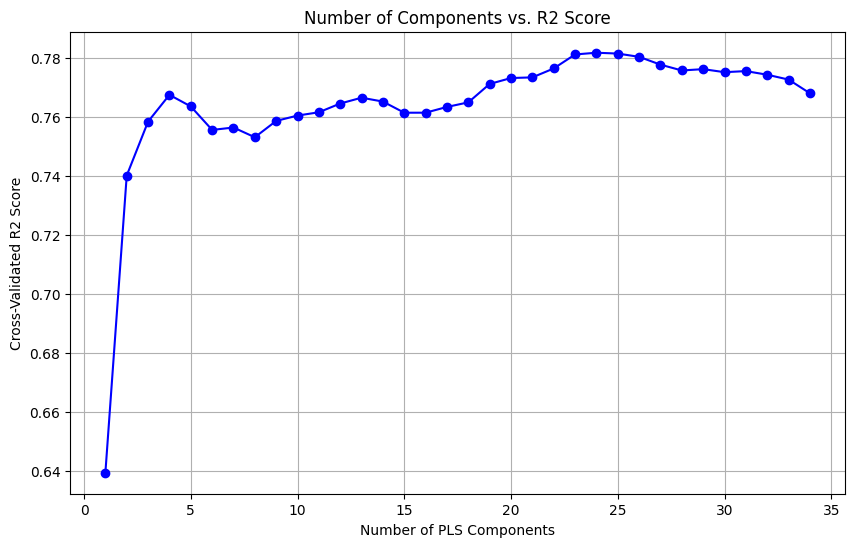

In [45]:
# Define groups for Leave-One-Group-Out cross-validation
groups = X_train['Bs_Batch'].values

# Ensure Y_train and Y_test are flattened
Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

# Initialize LeaveOneGroupOut for cross-validation
logo = LeaveOneGroupOut()

# Initialize lists to store the number of components and corresponding R^2 scores
component_list = []
r2_scores = []

# Perform cross-validation to find the optimal number of PLS components
for i in range(1, len(important_features)):
    pls = PLSRegression(n_components=i, scale=True)
    y_cv_pred = cross_val_predict(pls, X_train[important_features], Y_train, groups=groups, cv=logo)
    r2_cv = r2_score(Y_train, y_cv_pred)

    # Store the number of components and the corresponding R^2 score
    component_list.append(i)
    r2_scores.append(r2_cv)

# Plot the number of components against R^2 scores
plt.figure(figsize=(10, 6))
plt.plot(component_list, r2_scores, marker='o', linestyle='-', color='blue')
plt.title('Number of Components vs. R2 Score')
plt.xlabel('Number of PLS Components')
plt.ylabel('Cross-Validated R2 Score')
plt.grid(True)
plt.show()


In [46]:
# Define groups for Leave-One-Group-Out cross-validation using 'Bs_Batch' from X_train
groups = X_train['Bs_Batch'].values

# Ensure Y_train and Y_test are flattened if necessary
Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

# Initialize LeaveOneGroupOut for cross-validation
logo = LeaveOneGroupOut()

# Define PLS with 3 components
pls = PLSRegression(n_components=3, scale=True)

# Use cross_val_predict to get predictions for each fold
y_cv_pred = cross_val_predict(pls, X_train[important_features], Y_train, groups=groups, cv=logo)

# Calculate R² and MSE for the cross-validation predictions
r2_cv = r2_score(Y_train, y_cv_pred)
mse_cv = mean_squared_error(Y_train, y_cv_pred)

# Train the model on the entire training dataset
pls.fit(X_train[important_features], Y_train)

# Predict and evaluate on training and test sets
y_train_pred = pls.predict(X_train[important_features])
y_test_pred = pls.predict(X_test[important_features])

# Calculate MSE and R² for training and test sets, and compute RMSE for a better understanding of error magnitude
mse_train = mean_squared_error(Y_train, y_train_pred)
mse_test = mean_squared_error(Y_test, y_test_pred)
rmse_train = np.sqrt(mse_train)
rmse_test = np.sqrt(mse_test)
r2_train = r2_score(Y_train, y_train_pred)
r2_test = r2_score(Y_test, y_test_pred)

# Print the results
print(f"Using PLS with 3 components")
print(f"Cross-validation - Average R²: {r2_cv:.4f}, Average MSE: {mse_cv:.4f}")
print(f"Training set - RMSE: {rmse_train:.4f}, R²: {r2_train:.4f}")
print(f"Test set - RMSE: {rmse_test:.4f}, R²: {r2_test:.4f}")



Using PLS with 3 components
Cross-validation - Average R²: 0.7584, Average MSE: 0.0673
Training set - RMSE: 0.2290, R²: 0.8117
Test set - RMSE: 0.3934, R²: 0.6105


In [47]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # One row, two columns

# Subplot 1: Training Set
ax[0].scatter(Y_train, y_train_pred, alpha=0.5)
ax[0].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 'k--', lw=2)  # Line for perfect prediction
ax[0].set_xlabel('Actual Values', fontsize=17)
ax[0].set_ylabel('Predicted Values', fontsize=17)
ax[0].set_title('Scatterplot of Actual vs. Predicted Values (Training Set)', fontsize=18)
ax[0].tick_params(axis='both', which='major', labelsize=18)

# Subplot 2: Test Set
ax[1].scatter(Y_test, y_test_pred, alpha=0.5, color="red")
ax[1].plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=2)
ax[1].set_xlabel('Actual Values', fontsize=17)
ax[1].set_ylabel('Predicted Values', fontsize=17)
ax[1].set_title('Scatterplot of Actual vs. Predicted Values (Test Set)', fontsize=18)
ax[1].tick_params(axis='both', which='major', labelsize=17)

# Adjust layout to prevent label overlap
plt.tight_layout()

# Display the plots
plt.show()

lolo


/usr/local/lib/python3.10/dist-packages/hoggorm/plsr1.py:761: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.PRESSCVarr = np.array(list(self.PRESSCV_total_dict.values()))


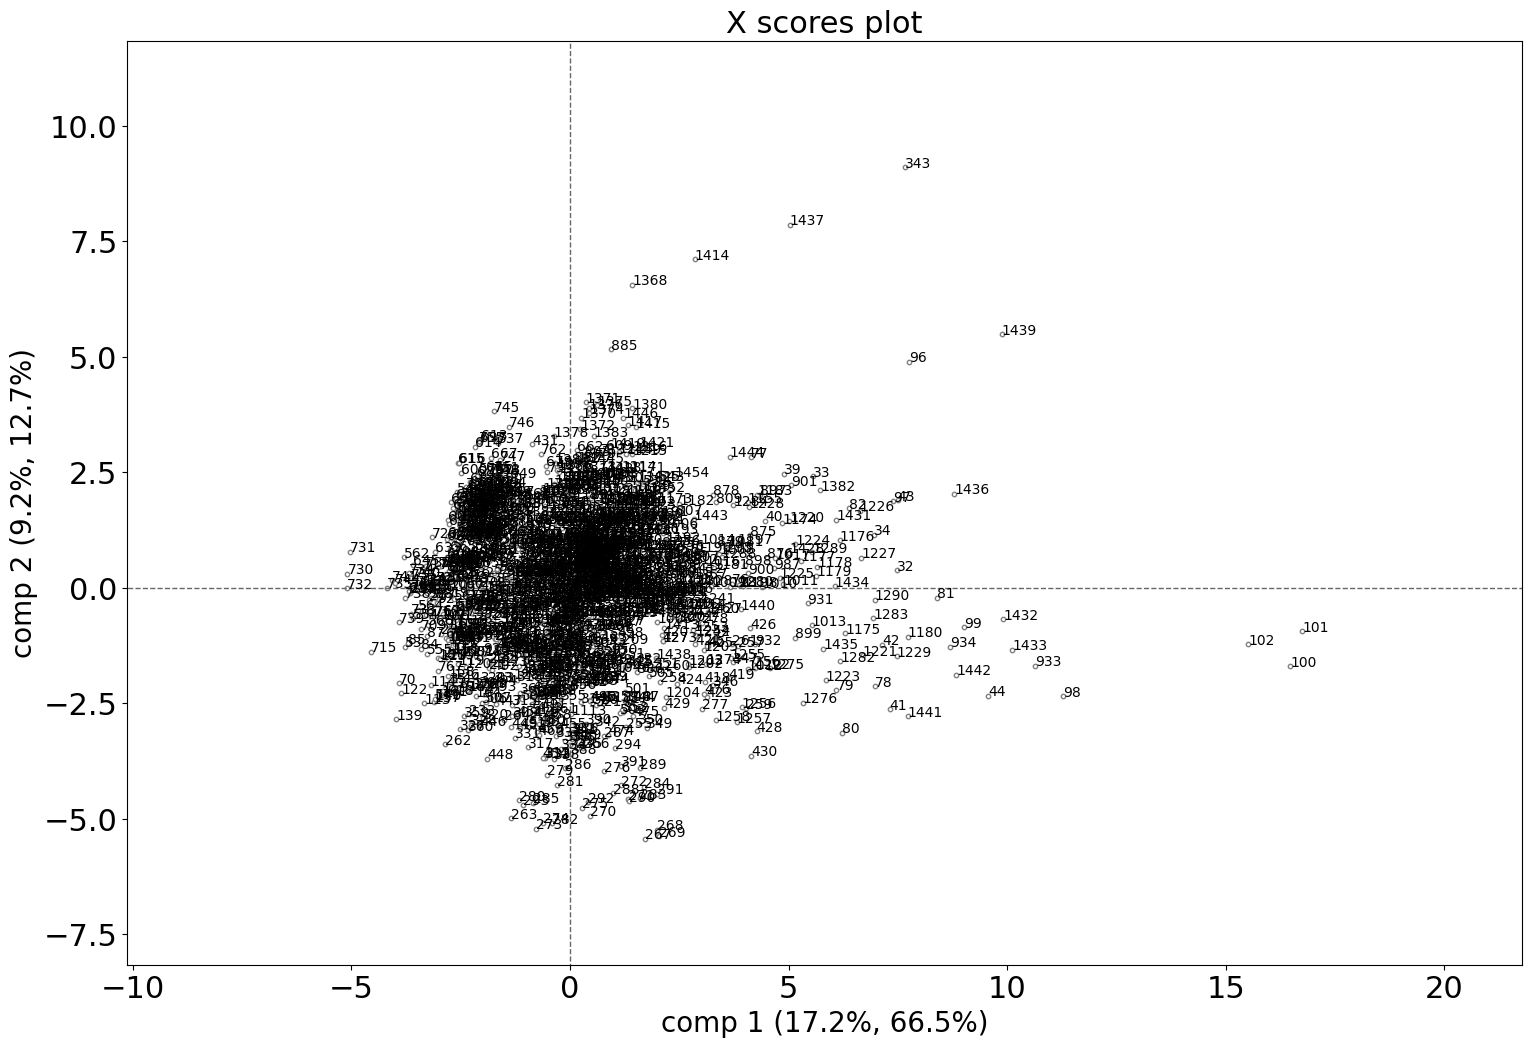

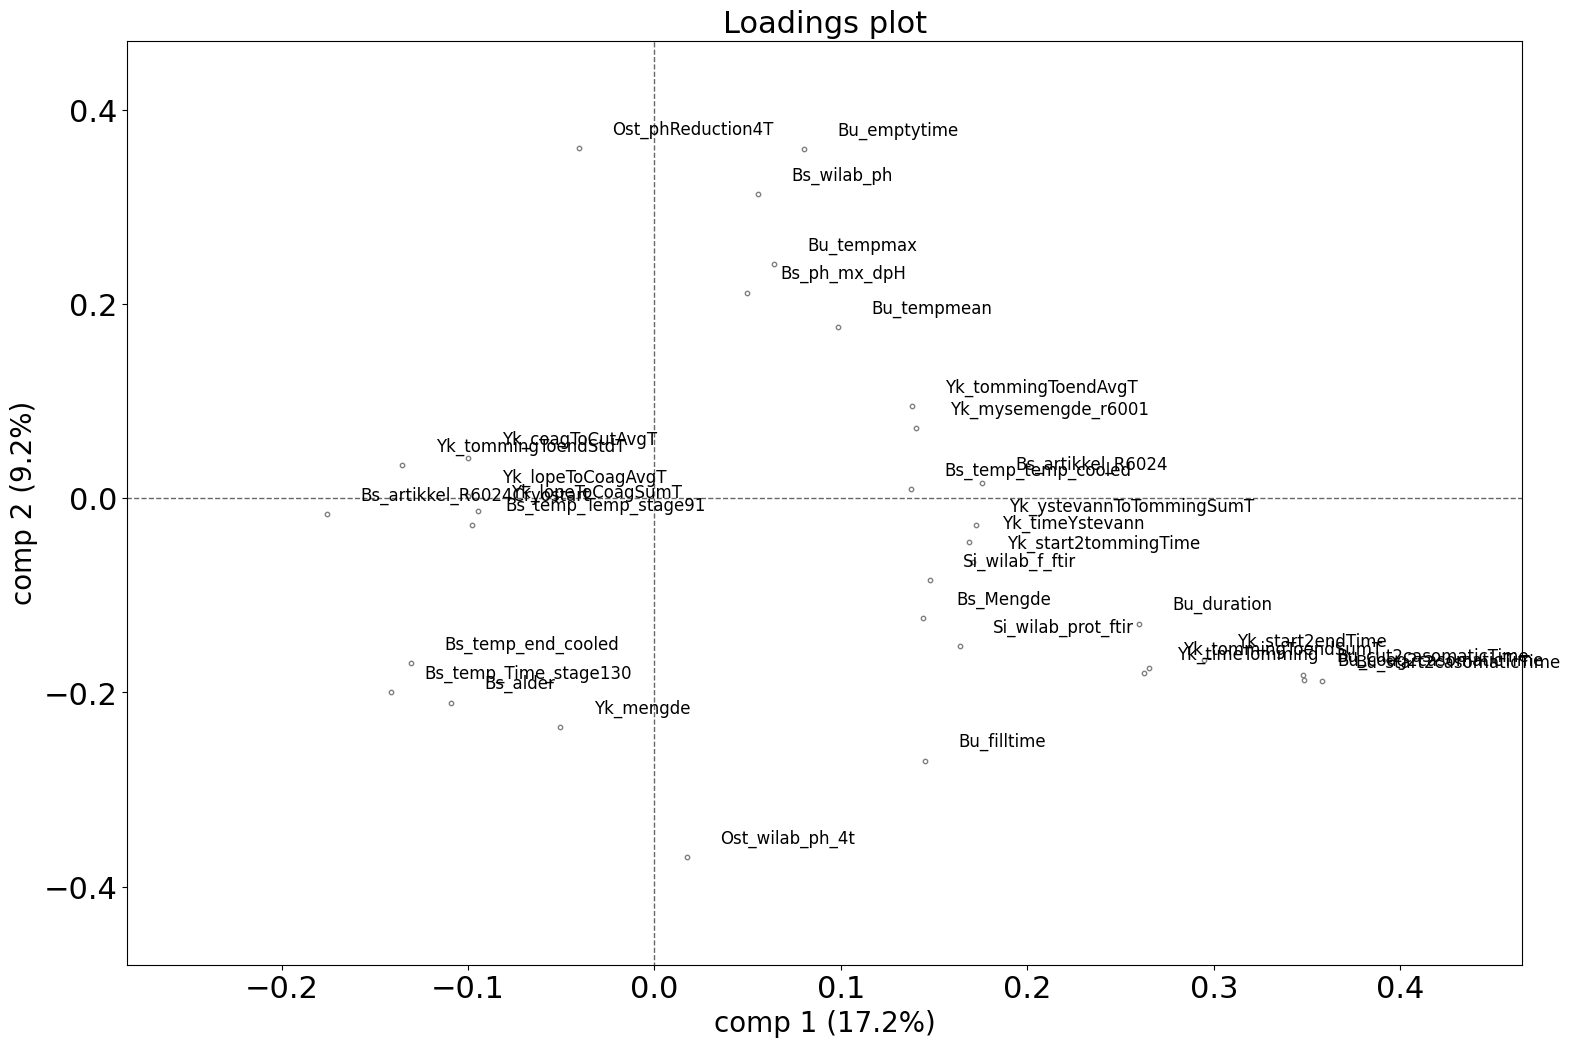

<Figure size 640x480 with 0 Axes>

In [50]:
plt.style.use('default')
plt.rc('font', size=20)
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)

# Convert Y_train to a DataFrame for compatibility with hoggorm
Y_train_df = pd.DataFrame(Y_train)

my_X_data = X_train[important_features].values
my_Y_data = Y_train_df.values

# Prepare groups for Leave-One-Out Cross-Validation by 'Bs_Batch'
groups = X_train['Bs_Batch'].values

myModel = ho.nipalsPLS1(arrX=my_X_data, vecy=my_Y_data, Xstand=True, Ystand=True, cvType=["lolo", groups])
XvarNames_list = list(X_train[important_features].columns)
objNames_list = X_train.index.astype(str).tolist()

# Generate plots for the model
fig = hop.plot(myModel, plots=[1, 2, 3, 4, 5, 6], XvarNames=XvarNames_list, objNames=objNames_list, YvarNames=['Ost_inlineTS'], figsize=(18, 12), comp=[1, 2], cumulative=True, validated=[True])
plt.tight_layout()
plt.show()

